In [3]:
import glob
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline

# Get Order of MDSs

In [62]:
mdss = []; labels = []

# read the log and extract the order of the MDSs
with open("logs/greedy-spill.log") as f:
    for line in f:
        if "fsmap e" in line:
            del mdss[:]
            for w in line.split()[-1].split('='):
                if "mds-" in w:
                    mdss.append(w.strip("mds-"))
print mdss

# setup the MDS labels for graphing
for i in range(0, len(mdss)):
    labels.append("MDS" + str(i))

['issdm-12', 'issdm-15', 'issdm-18']


# Graph Helpers

In [56]:
# graph settings
PLT_ARGS = {'linewidth': 2.0}
PNG_ARGS = {'dpi': 300, 'bbox_inches': 'tight'}
PARSEARG = {'engine': 'python', 'header': None, 'sep': (",|:"), 'skiprows': 13}

def mds_label(fname, metric):
    rank = os.path.basename(fname)
    rank = rank.strip('.out').strip(metric+'-')
    rank = mdss.index(rank)
    site = os.path.dirname(fname)
    site = os.path.dirname(site)
    return site + "-MDS"+str(rank)

def site_label(fname):
    return os.path.dirname(fname)

# read in traces and find first timestamp
def read_traces(fnames, metric):
    min_ts = 1.7976931348623157e+308
    PARSEARG['names'] = ("seconds", metric)
    traces = {}
    for f in fnames:
        try:                                         # in case trace has no data
            traces[f] = pd.read_table(f, **PARSEARG) # read with parser specified by PARSE_ARGS
            if traces[f]['seconds'][0] < min_ts:     # find minimum timestamp
                min_ts = traces[f]['seconds'][0]
        except:
            pass
    return traces, min_ts

# plot the metrics over time in MDS rank order
def plot_whisperdb(fnames):
    if 'cpu' in fnames[0]: metric = 'cpu'
    else: metric = 'reply'
    
    traces, min_ts = read_traces(fnames, metric)
    ax = plt.figure().add_subplot(111)
    for mds in mdss:
        for f in traces:
            if mds in f:
                trace = traces[f]
                trace = trace[trace.seconds != 0]    # ignore timestamps carbon did't get any metrics    
                ax.plot(trace['seconds'] - min_ts,   # slide x axis to start at 0
                        trace[metric],               # plot the raw cpu 
                        label=mds_label(f, metric),         
                        **PLT_ARGS)
    ax.legend(loc='upper left')
    ax.legend(bbox_to_anchor=(1.5, 1.05))

# Per-MDS CPU Utilization

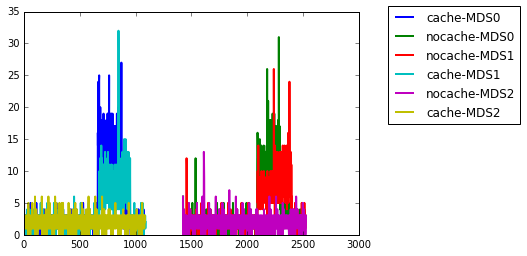

In [57]:
fnames = glob.glob("*cache/utilization/cpu*.out")
plot_whisperdb(fnames)

# Per-MDS Request Throughput

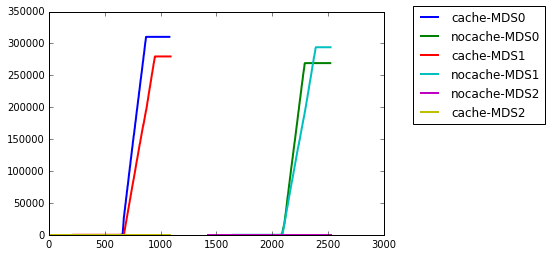

In [58]:
fnames = glob.glob("*cache/utilization/reply*.out")
plot_whisperdb(fnames)

# Per-MDS Load

In [65]:
# parse MDS0's log
def parse_mds_log(fname):
    df = pd.DataFrame(columns=tuple(mdss))
    with open(fname) as f:
        for line in f:
            if "load=" in line and "MDS" in line:
                words = line.split()
                for w in words:
                    if "load=" in w:
                        if "MDS0" == words[words.index(w)-1]: 
                            temp = []
                        temp.append(w.split('=')[1])
                        if len(temp) >= len(mdss):
                            df.loc[len(df)] = temp
    return df

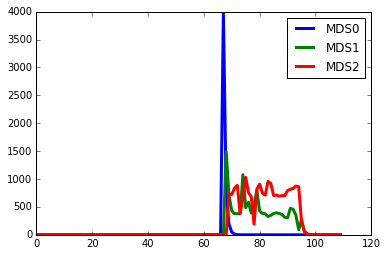

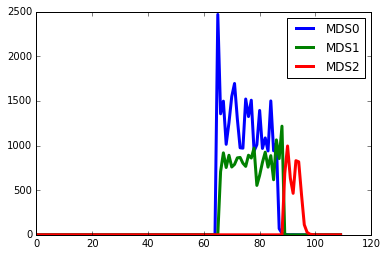

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)
df = parse_mds_log("cache/logs/" + mdss[0] + "-daemon.log")
ax.plot(df, linewidth=3.0)
ax.legend(labels)

fig = plt.figure()
ax = fig.add_subplot(111)
df = parse_mds_log("nocache/logs/" + mdss[0] + "-daemon.log")
ax.plot(df, linewidth=3.0)
ax.legend(labels)